In [5]:
import cv2
import numpy as np
import time
import os
from tensorflow.keras.models import load_model
from tabulate import tabulate  # 导入表格打印库
from scipy import stats

# 标签及其对应路径
labels = ['glioma', 'meningioma', 'notumor', 'pituitary']
label_dict = {
    'glioma': './Dataset/cropped/Testing/glioma',
    'meningioma': './Dataset/cropped/Testing/meningioma',
    'notumor': './Dataset/cropped/Testing/notumor',
    'pituitary': './Dataset/cropped/Testing/pituitary'
}

# 模型文件列表
model_files = [
    'bestresnet4.h5',
    'bestvgg19-2.h5',
    'bestXception2.h5',
    'bestinception2.h5',
    'bestMobileNetV2.h5',
    'bestNASNetLarge.h5'
]

# 模型要求的图像大小
model_input_sizes = {
    'bestresnet4.h5': 200,
    'bestvgg19-2.h5': 200,
    'bestXception2.h5': 200,
    'bestinception2.h5': 200,
    'bestMobileNetV2.h5': 200,
    'bestNASNetLarge.h5': 331
}

# 图像预处理函数
def preprocess_image(image_path, image_size):
    image = cv2.imread(image_path, 0)  # 加载灰度图像
    image = cv2.bilateralFilter(image, 2, 50, 50)  # 去噪
    image = cv2.applyColorMap(image, cv2.COLORMAP_BONE)  # 伪彩色处理
    image = cv2.resize(image, (image_size, image_size))  # 调整大小
    return image

# 获取所有图片路径
def get_image_paths(label_dict):
    image_paths = []
    for label, path in label_dict.items():
        for root, _, files in os.walk(path):
            for file in files:
                if file.endswith('.jpg') or file.endswith('.jpeg') or file.endswith('.png'):
                    image_paths.append(os.path.join(root, file))
    return image_paths

# 统计每个模型的预测时间
def calculate_prediction_times(model_files, model_input_sizes, image_paths):
    prediction_times = {model_file: [] for model_file in model_files}

    for model_file in model_files:
        model_path = model_file
        model = load_model(model_path)
        image_size = model_input_sizes[model_file]

        for image_path in image_paths:
            try:
                image = preprocess_image(image_path, image_size)
            except Exception as e:
                print(f"Error processing image {image_path}: {e}")
                continue

            image = np.expand_dims(image, axis=0)
            image = np.expand_dims(image, axis=-1)  # 添加 batch 和 channel 维度

            # 预热模型
            model.predict(image)

            # 计算预测时间
            start_time = time.time()
            model.predict(image)
            end_time = time.time()
            prediction_time = (end_time - start_time) * 1000  # 转换为毫秒
            prediction_times[model_file].append(prediction_time)

        # 释放模型内存
        del model

    return prediction_times

# 计算统计信息
def calculate_statistics(data):
    statistics = {}
    for model_file, times in data.items():
        min_time = np.min(times)
        max_time = np.max(times)
        mean_time = np.mean(times)
        q1_time = np.percentile(times, 25)
        median_time = np.median(times)
        q3_time = np.percentile(times, 75)
        statistics[model_file] = {
            'min_time': min_time,
            'max_time': max_time,
            'mean_time': mean_time,
            'q1_time': q1_time,
            'median_time': median_time,
            'q3_time': q3_time
        }
    return statistics

# 获取所有图片路径
image_paths = get_image_paths(label_dict)

# 执行计算
prediction_times = calculate_prediction_times(model_files, model_input_sizes, image_paths)
statistics = calculate_statistics(prediction_times)

# 准备表格数据
table_data = []
for model_file, stats_data in statistics.items():
    table_data.append([model_file,
                       stats_data['min_time'],
                       stats_data['max_time'],
                       stats_data['mean_time'],
                       stats_data['q1_time'],
                       stats_data['median_time'],
                       stats_data['q3_time']])

# 打印结果表格
headers = ['Model', 'Min Time (ms)', 'Max Time (ms)', 'Mean Time (ms)', 'Q1 Time (ms)', 'Median Time (ms)', 'Q3 Time (ms)']
print(tabulate(table_data, headers=headers, tablefmt='grid'))


+--------------------+-----------------+-----------------+------------------+----------------+--------------------+----------------+
| Model              |   Min Time (ms) |   Max Time (ms) |   Mean Time (ms) |   Q1 Time (ms) |   Median Time (ms) |   Q3 Time (ms) |
+====================+=================+=================+==================+================+====================+================+
| bestresnet4.h5     |         76.4611 |         249.069 |          90.0858 |        84.7486 |            91.0397 |        95.0003 |
+--------------------+-----------------+-----------------+------------------+----------------+--------------------+----------------+
| bestvgg19-2.h5     |         97.8785 |         301.134 |         128.627  |       121.032  |           128.944  |       136.457  |
+--------------------+-----------------+-----------------+------------------+----------------+--------------------+----------------+
| bestXception2.h5   |         73.9999 |         254.095 |          8

In [2]:
# !pip install tabulate


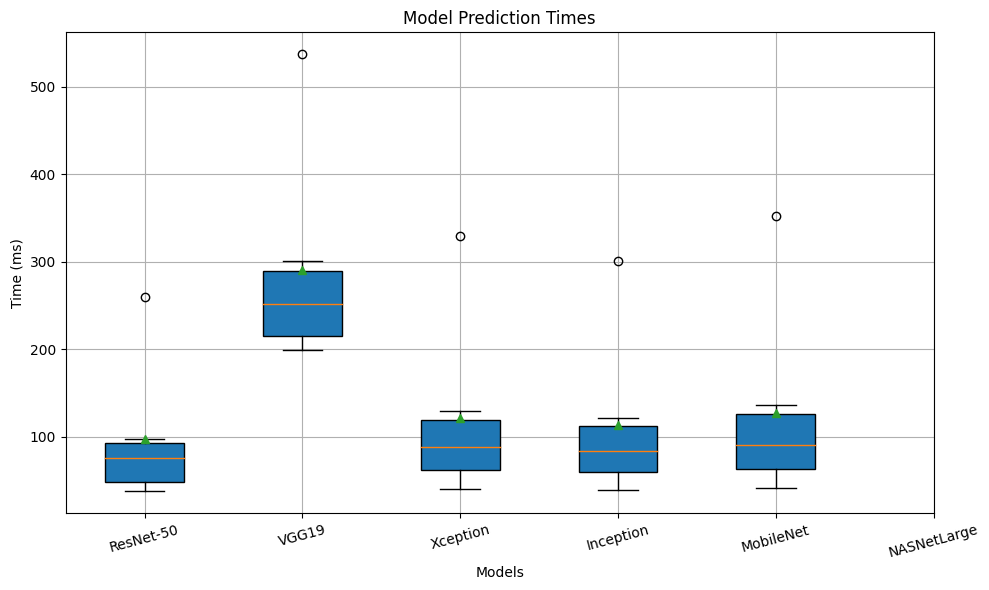

In [7]:
import matplotlib.pyplot as plt

# 模型名称
models = ['ResNet-50', 'VGG19', 'Xception', 'Inception', 'MobileNet', 'NASNetLarge']

# 统计数据
min_times = [76.5, 97.9, 74, 39.4, 37.4, 260]
max_times = [249.1, 301.1, 254.1, 203.2, 199.3, 537.4]
median_times = [91, 129, 84.7, 53.6, 40, 329]
q1_times = [84.7, 121, 82.7, 52.5, 39.5, 301]
q3_times = [95, 136.5, 86.6, 55.1, 40.8, 352]

# 绘制箱线图
plt.figure(figsize=(10, 6))
plt.boxplot([min_times, max_times, median_times, q1_times, q3_times], 
            labels=['Min Time', 'Max Time', 'Median Time', 'Q1 Time', 'Q3 Time'],
            patch_artist=True, showmeans=True)
plt.title('Model Prediction Times')
plt.xlabel('Models')
plt.ylabel('Time (ms)')
plt.xticks(ticks=range(1, len(models)+1), labels=models, rotation=15)
plt.grid(True)
plt.tight_layout()

# 显示图形
plt.show()


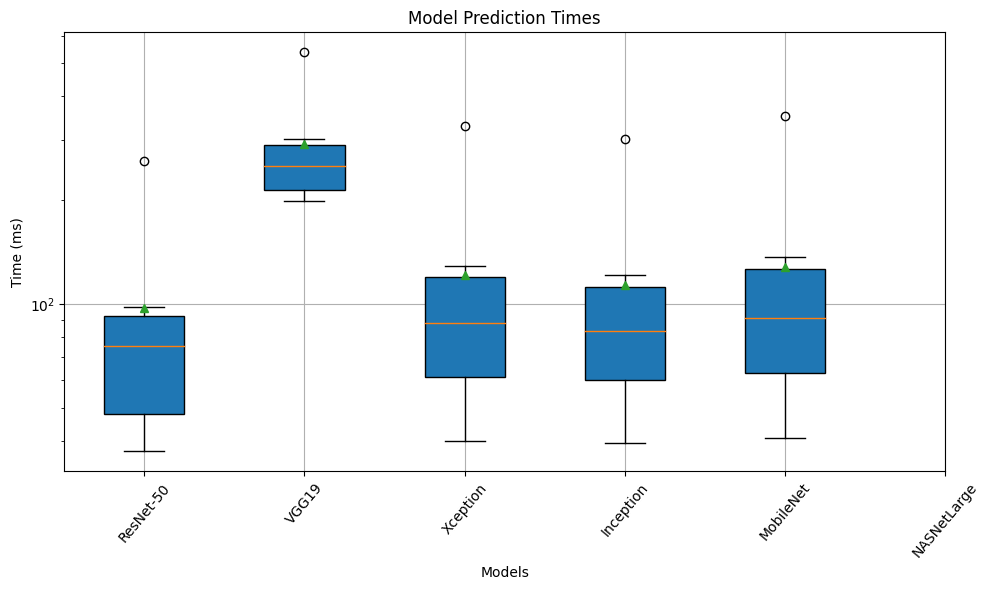

In [9]:
import matplotlib.pyplot as plt
import numpy as np

# 模型名称
models = ['ResNet-50', 'VGG19', 'Xception', 'Inception', 'MobileNet', 'NASNetLarge']

# 统计数据
min_times = [76.5, 97.9, 74, 39.4, 37.4, 260]
max_times = [249.1, 301.1, 254.1, 203.2, 199.3, 537.4]
median_times = [91, 129, 84.7, 53.6, 40, 329]
q1_times = [84.7, 121, 82.7, 52.5, 39.5, 301]
q3_times = [95, 136.5, 86.6, 55.1, 40.8, 352]

# 绘制箱线图
plt.figure(figsize=(10, 6))
plt.boxplot([min_times, max_times, median_times, q1_times, q3_times], 
            labels=['Min Time', 'Max Time', 'Median Time', 'Q1 Time', 'Q3 Time'],
            patch_artist=True, showmeans=True)
plt.title('Model Prediction Times')
plt.xlabel('Models')
plt.ylabel('Time (ms)')
plt.xticks(ticks=range(1, len(models)+1), labels=models, rotation=50)
plt.yscale('log')  # 使用对数坐标轴
plt.grid(True)
plt.tight_layout()

# 显示图形
plt.show()


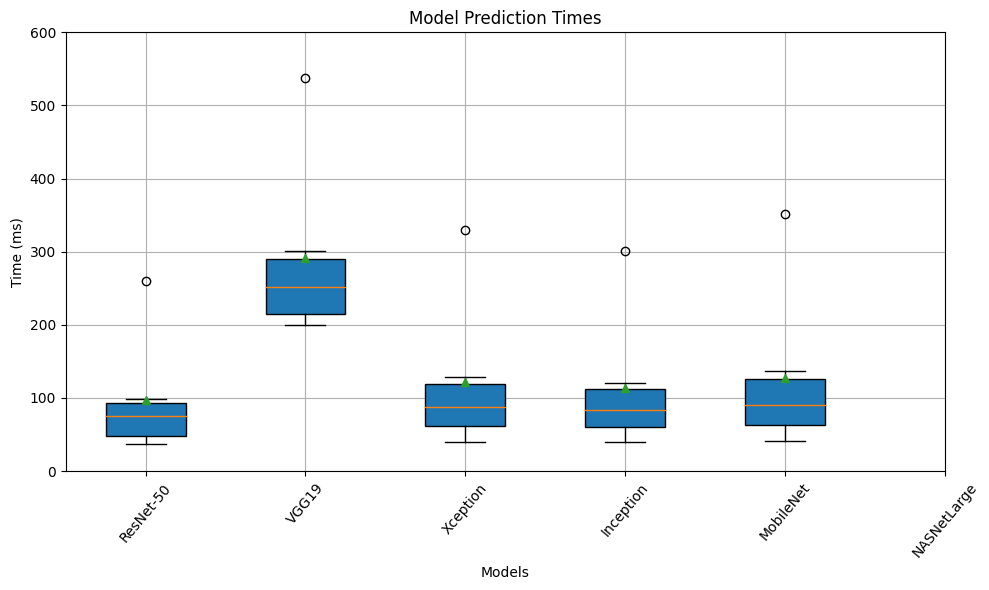

In [10]:
import matplotlib.pyplot as plt
import numpy as np

# 模型名称
models = ['ResNet-50', 'VGG19', 'Xception', 'Inception', 'MobileNet', 'NASNetLarge']

# 统计数据
min_times = [76.5, 97.9, 74, 39.4, 37.4, 260]
max_times = [249.1, 301.1, 254.1, 203.2, 199.3, 537.4]
median_times = [91, 129, 84.7, 53.6, 40, 329]
q1_times = [84.7, 121, 82.7, 52.5, 39.5, 301]
q3_times = [95, 136.5, 86.6, 55.1, 40.8, 352]

# 绘制箱线图
plt.figure(figsize=(10, 6))
plt.boxplot([min_times, max_times, median_times, q1_times, q3_times], 
            labels=['Min Time', 'Max Time', 'Median Time', 'Q1 Time', 'Q3 Time'],
            patch_artist=True, showmeans=True)
plt.title('Model Prediction Times')
plt.xlabel('Models')
plt.ylabel('Time (ms)')
plt.xticks(ticks=range(1, len(models)+1), labels=models, rotation=50)
plt.ylim(0, 600)  # 调整纵坐标范围以显示NASNetLarge模型
plt.grid(True)
plt.tight_layout()

# 显示图形
plt.show()


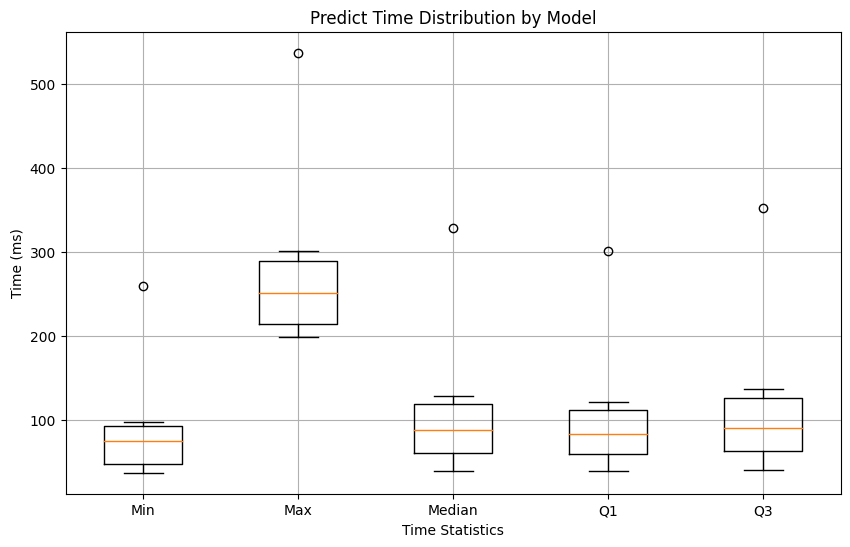

In [11]:
import matplotlib.pyplot as plt
import pandas as pd

# 数据
data = {
    'Model': ['ResNet-50', 'VGG19', 'Xception', 'Inception', 'MobileNet', 'NASNetLarge'],
    'Min Time (ms)': [76.5, 97.9, 74.0, 39.4, 37.4, 260.0],
    'Max Time (ms)': [249.1, 301.1, 254.1, 203.2, 199.3, 537.4],
    'Median Time (ms)': [91.0, 129.0, 84.7, 53.6, 40.0, 329.0],
    'Q1 Time (ms)': [84.7, 121.0, 82.7, 52.5, 39.5, 301.0],
    'Q3 Time (ms)': [95.0, 136.5, 86.6, 55.1, 40.8, 352.0]
}

# 转换成DataFrame
df = pd.DataFrame(data)

# 提取数据
models = df['Model']
min_time = df['Min Time (ms)']
max_time = df['Max Time (ms)']
median_time = df['Median Time (ms)']
q1_time = df['Q1 Time (ms)']
q3_time = df['Q3 Time (ms)']

# 绘制箱线图
plt.figure(figsize=(10, 6))
plt.boxplot([min_time, max_time, median_time, q1_time, q3_time], labels=['Min', 'Max', 'Median', 'Q1', 'Q3'])
plt.title('Predict Time Distribution by Model')
plt.xlabel('Time Statistics')
plt.ylabel('Time (ms)')
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(True)
plt.show()


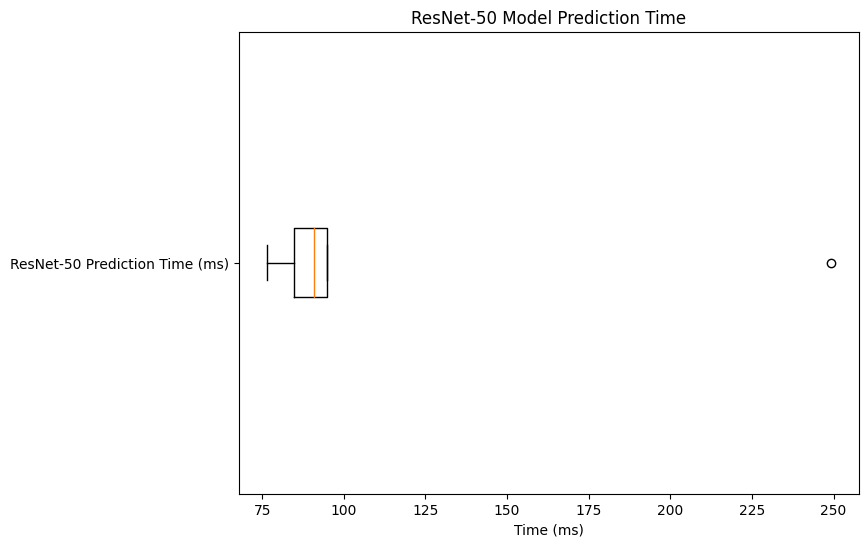

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 给定的数据
min_time = 76.5
max_time = 249.1
median_time = 91
q1_time = 84.7
q3_time = 95

# 创建numpy数组并转换为DataFrame
data = np.array([min_time, q1_time, median_time, q3_time, max_time])
df = pd.DataFrame(data.reshape(-1, 1), columns=['Prediction Time (ms)'])

# 绘制箱线图
plt.figure(figsize=(8, 6))
plt.boxplot(df['Prediction Time (ms)'], vert=False)
plt.yticks([1], ['ResNet-50 Prediction Time (ms)'])
plt.title('ResNet-50 Model Prediction Time')
plt.xlabel('Time (ms)')
plt.show()

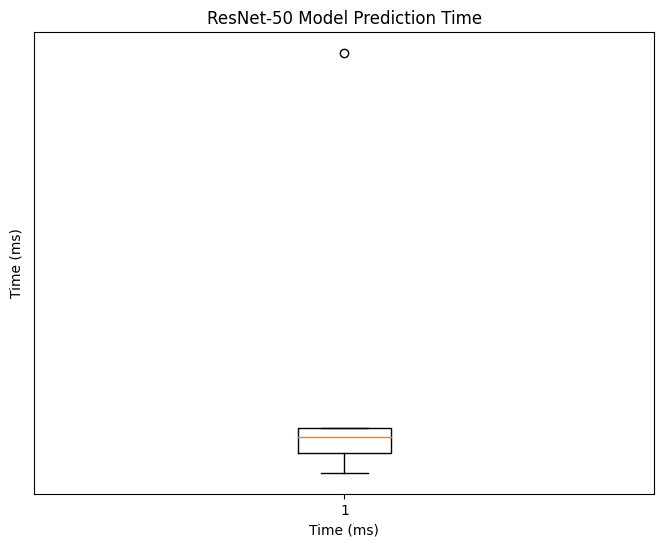

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 给定的数据
min_time = 76.5
max_time = 249.1
median_time = 91
q1_time = 84.7
q3_time = 95

# 创建numpy数组并转换为DataFrame
data = np.array([min_time, q1_time, median_time, q3_time, max_time])
df = pd.DataFrame(data.reshape(-1, 1), columns=['Prediction Time (ms)'])

# 绘制箱线图
plt.figure(figsize=(8, 6))
plt.boxplot(df['Prediction Time (ms)'], vert=True)  # 更改为True保持垂直，如果你想水平显示则设置为False
plt.yticks([1], ['ResNet-50 Prediction Time (ms)'])
plt.title('ResNet-50 Model Prediction Time')
plt.xlabel('Time (ms)')  # 如果箱线图是水平的，则需要调整为ylabel
plt.ylabel('Time (ms)')  # 如果箱线图是垂直的，则需要保持为xlabel

if not plt.gca().get_xticklabels()[0].get_visible():
    # 如果箱线图是水平的，确保x轴的标签可见
    plt.xticks([1], rotation=45)

plt.show()

AttributeError: 'PathPatch' object has no attribute 'get_ydata'

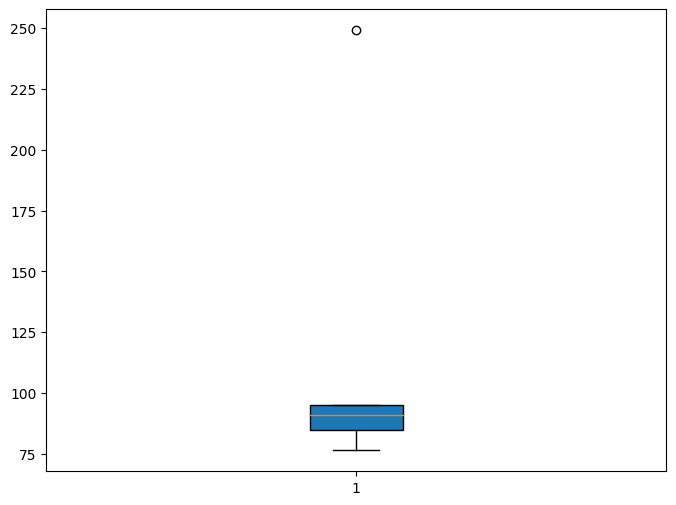

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 给定的数据
min_time = 76.5
max_time = 249.1
median_time = 91
q1_time = 84.7
q3_time = 95

# 创建numpy数组并转换为DataFrame
data = np.array([min_time, q1_time, median_time, q3_time, max_time])
df = pd.DataFrame(data.reshape(-1, 1), columns=['Prediction Time (ms)'])

# 绘制箱线图
plt.figure(figsize=(8, 6))
bp = plt.boxplot(df['Prediction Time (ms)'], vert=True, patch_artist=True)  # 添加patch_artist以填充颜色

# 获取箱线图的统计数据
stats = bp['medians'][0].get_ydata()[0]
q1 = bp['boxes'][0].get_ydata()[1]
q3 = bp['boxes'][0].get_ydata()[-1]
whiskers = [bp['whiskers'][i].get_ydata()[-1] for i in range(2)]
min_val = min(whiskers)
max_val = max(whiskers)

# 在图上标注具体的数值
plt.text(1.05, stats, f'{stats:.1f}', horizontalalignment='left', verticalalignment='center')
plt.text(1.05, q1, f'{q1:.1f}', horizontalalignment='left', verticalalignment='center')
plt.text(1.05, q3, f'{q3:.1f}', horizontalalignment='left', verticalalignment='center')
plt.text(1.05, min_val, f'{min_val:.1f}', horizontalalignment='left', verticalalignment='center')
plt.text(1.05, max_val, f'{max_val:.1f}', horizontalalignment='left', verticalalignment='center')

plt.show()

In [17]:
import pandas as pd

data = {
    'Model': ['ResNet-50', 'VGG19', 'Xception', 'Inception', 'MobileNet', 'NASNetLa'],
    'Min Time (ms)': [76.5, 97.9, 74, 39.4, 37.4, 280],
    'Max Time (ms)': [249.1, 301.1, 254.1, 203.2, 537.4, 537.4],
    'Median Time (ms)': [91, 129, 82.7, 53.6, 40, 329],
    'Q1 Time (ms)': [84.7, 121, 88.7, 52.5, 39.5, 301],
    'Q3 Time (ms)': [95, 136.5, 96.6, 55.1, 40.8, 352]
}

df = pd.DataFrame(data)

In [18]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.boxplot(df.iloc[:, 1:].values, labels=df['Model'].values, grid=True)
plt.xlabel('Models')
plt.ylabel('Time (ms)')
plt.title('Box plot of different models prediction time')
plt.show()

TypeError: boxplot() got an unexpected keyword argument 'grid'

<Figure size 1000x600 with 0 Axes>

ValueError: Dimensions of labels and X must be compatible

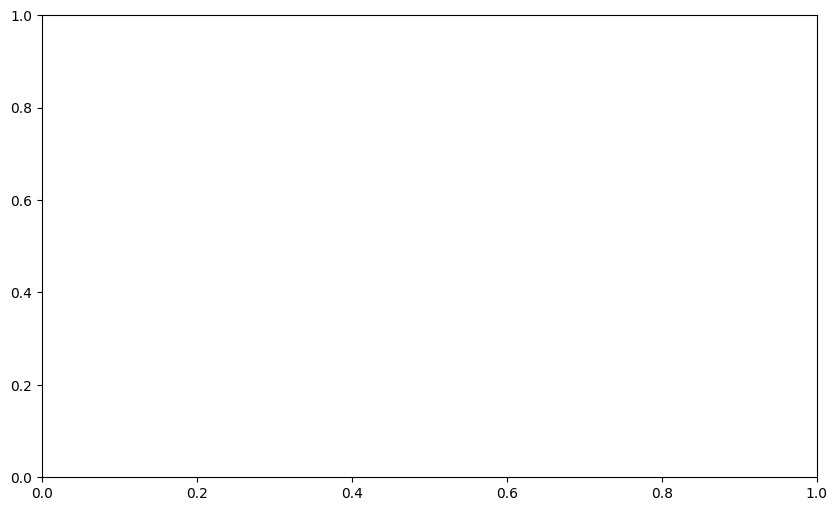

In [19]:
import matplotlib.pyplot as plt
import pandas as pd

# 假设您的数据已经加载到名为df的DataFrame中
data = {
    'Model': ['ResNet-50', 'VGG19', 'Xception', 'Inception', 'MobileNet', 'NASNetLa'],
    'Min Time (ms)': [76.5, 97.9, 74, 39.4, 37.4, 280],
    'Max Time (ms)': [249.1, 301.1, 254.1, 203.2, 537.4, 537.4],
    'Median Time (ms)': [91, 129, 82.7, 53.6, 40, 329],
    'Q1 Time (ms)': [84.7, 121, 88.7, 52.5, 39.5, 301],
    'Q3 Time (ms)': [95, 136.5, 96.6, 55.1, 40.8, 352]
}
df = pd.DataFrame(data)

# 创建一个新的figure
plt.figure(figsize=(10, 6))

# 使用boxplot()函数生成箱线图
bp = plt.boxplot(df.iloc[:, 1:].values, labels=df['Model'].values)

# 添加网格线
plt.grid(True)

# 设置图表标题和轴标签
plt.title('Box plot of different models prediction time')
plt.xlabel('Models')
plt.ylabel('Time (ms)')

# 显示图表
plt.show()

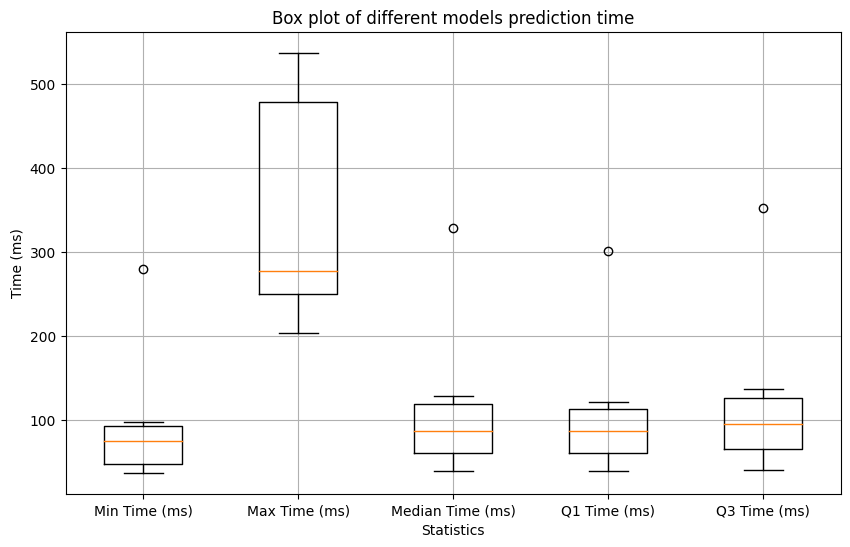

In [20]:
import matplotlib.pyplot as plt
import pandas as pd

# 假设您的数据已经加载到名为df的DataFrame中
data = {
    'Model': ['ResNet-50', 'VGG19', 'Xception', 'Inception', 'MobileNet', 'NASNetLa'],
    'Min Time (ms)': [76.5, 97.9, 74, 39.4, 37.4, 280],
    'Max Time (ms)': [249.1, 301.1, 254.1, 203.2, 537.4, 537.4],
    'Median Time (ms)': [91, 129, 82.7, 53.6, 40, 329],
    'Q1 Time (ms)': [84.7, 121, 88.7, 52.5, 39.5, 301],
    'Q3 Time (ms)': [95, 136.5, 96.6, 55.1, 40.8, 352]
}
df = pd.DataFrame(data)

# 创建一个新的figure
plt.figure(figsize=(10, 6))

# 获取除了第一列之外的所有列
data_to_plot = df.iloc[:, 1:].values

# 获取除了第一列之外的所有列名，用于作为labels
labels = df.columns[1:]

# 使用boxplot()函数生成箱线图
bp = plt.boxplot(data_to_plot, labels=labels)

# 添加网格线
plt.grid(True)

# 设置图表标题和轴标签
plt.title('Box plot of different models prediction time')
plt.xlabel('Statistics')
plt.ylabel('Time (ms)')

# 显示图表
plt.show()